### Load libraries

In [1]:
from typing import Any, Callable, Optional, Sequence

import flax
import jax
import matplotlib.pyplot as plt
import optax
from flax import linen as nn
from flax.core import freeze, unfreeze
from jax import lax
from jax import numpy as jnp

jnp.arange(0) # Prints out any jax warnings. 

DeviceArray([], dtype=int32)

### Define generator neural network

In [6]:
class MLP(nn.Module):
    """From https://flax.readthedocs.io/en/latest/notebooks/flax_basics.html"""

    layer_widths: Sequence[int]

    def setup(self):
        self.layers = [
            nn.Dense(
                feat,
                kernel_init=nn.initializers.he_normal(),
            )
            for feat in self.layer_widths
        ]

    def __call__(self, x):
        for lyr in self.layers[:-1]:
            x = lyr(x)
            x = nn.relu(x)

        return self.layers[-1](x)

In [7]:
def get_random_model(
    input_dim: int = 2,
    layer_widths: Sequence[int] = [96, 192, 1],
    seed: int = 42,
) -> tuple[nn.Module, nn.FrozenDict]:
    """
    [96, 192, 1] is from https://arxiv.org/pdf/2102.06701.pdf.
    """
    model = MLP(layer_widths)
    params = model.init(
        jax.random.PRNGKey(seed),
        jnp.zeros(input_dim),
    )

    return model, params


m, p = get_random_model()
m.apply(p, [0.5, 0.5])

DeviceArray([0.9538772], dtype=float32)

### Visualize neural net as image

In [8]:
def unit_sq_sampling(side_samples: int):
    xs, ys = jnp.meshgrid(
        jnp.linspace(0, 1, side_samples),
        jnp.linspace(0, 1, side_samples),
    )
    return jnp.stack([xs, ys]).T
    
unit_sq_sampling(30).shape

(30, 30, 2)

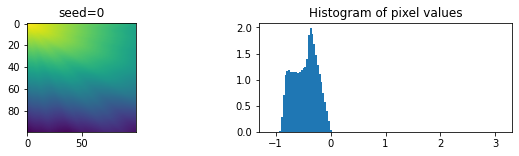

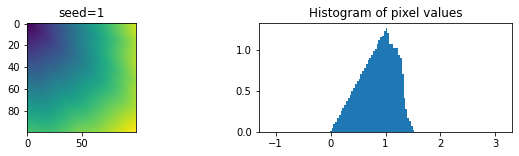

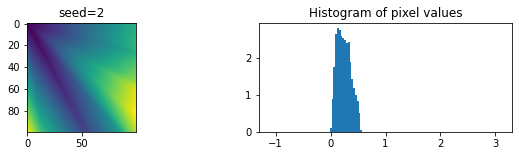

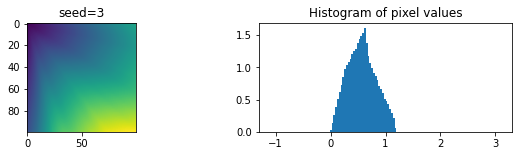

In [18]:
def get_model_img(
    side_samples: int,
    model: nn.Module,
    params: nn.FrozenDict,
) -> jnp.ndarray:
    XY = unit_sq_sampling(side_samples)
    assert XY.shape == (side_samples, side_samples, 2)

    return model.apply(
        params,
        XY,
    ).squeeze(-1)


for seed in range(4):
    m, p = get_random_model(
        layer_widths=[96, 192, 32, 4, 1],
        seed=seed,
    )

    img = get_model_img(100, m, p)

    plt.figure(figsize=(10, 2))

    plt.subplot(1, 2, 1)
    plt.title(f"{seed=}")
    plt.imshow(img)

    plt.subplot(1, 2, 2)
    plt.title("Histogram of pixel values")
    plt.hist(img.flatten(), bins=128, range=(-1.1, 3.1), density=True)

    plt.show();

## DFT and DCT

In [20]:
def get_shifted_dft(img: jnp.ndarray) -> jnp.ndarray:
    """
    If img is NxN, then
    img[x, y] = sum_{a, b} dft[a, b] * exp(2 * pi * i * (a * x + b * y) / N)
    """

    dft = jnp.fft.fft2(img) / img.size  # Normalize by size
    shifted_dft = jnp.roll(
        jnp.roll(dft, img.shape[0] // 2, axis=0),
        img.shape[0] // 2,
        axis=1,
    )
    return shifted_dft


def get_shifted_dct2(img: jnp.ndarray) -> jnp.ndarray:
    dct = jax.scipy.fft.dct(
        jax.scipy.fft.dct(img.T, norm="ortho").T,
        norm="ortho",
    )
    shifted_dct = jnp.roll(
        jnp.roll(dct, img.shape[0] // 2, axis=0),
        img.shape[0] // 2,
        axis=1,
    )
    return shifted_dct

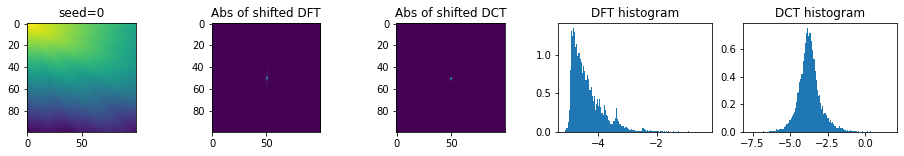

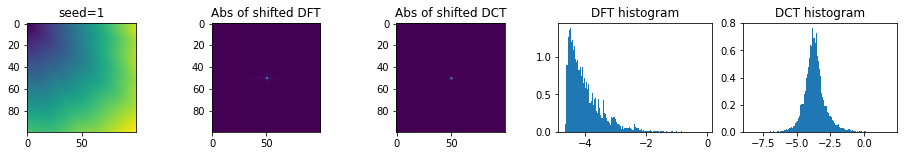

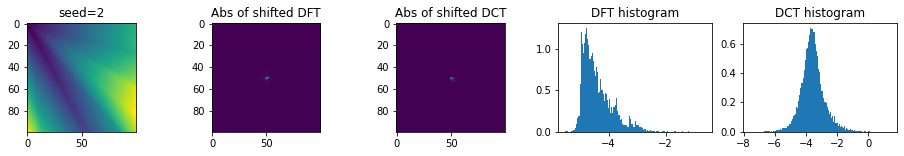

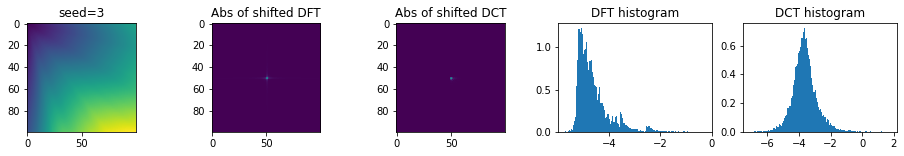

In [21]:
for seed in range(4):
    m, p = get_random_model(
        layer_widths=[96, 192, 32, 4, 1],
        seed=seed,
    )

    img = get_model_img(100, m, p)

    sdft = get_shifted_dft(img)
    sdct = get_shifted_dct2(img)

    plt.figure(figsize=(16, 2))
    plt.subplot(1, 5, 1)
    plt.title(f"{seed=}")
    plt.imshow(img)

    plt.subplot(1, 5, 2)
    plt.title("Abs of shifted DFT")
    plt.imshow(jnp.abs(sdft))
    
    plt.subplot(1, 5, 3)
    plt.title("Abs of shifted DCT")
    plt.imshow(jnp.abs(sdct))

    plt.subplot(1, 5, 4)
    plt.title("DFT histogram")
    plt.hist(
        jnp.log10(jnp.abs(sdft).flatten()),
        bins=128,
        density=True,
    );
    
    plt.subplot(1, 5, 5)
    plt.title("DCT histogram")
    plt.hist(
        jnp.log10(jnp.abs(sdct).flatten()),
        bins=128,
        density=True,
    );

# Conclusions
Randomly initialized neural networks of the type
$\mathbb{R}^2 \to \mathbb{R}$
are pretty low-frequency.